In [1]:
# Imports
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, Lambda, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy, MeanSquaredError

In [ ]:
# Using wget to download the CelebA dataset (aligned and cropped version)
!wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip

# Unzipping the dataset
!unzip celeba.zip

In [4]:
# Load the partitioning file
df_partition = pd.read_csv('/content/list_eval_partition.txt', delim_whitespace=True, header=None, names=['filename', 'partition'])

# Get appropriate filenames
train_filenames = df_partition[df_partition['partition'] == 0]['filename'].tolist()
val_filenames = df_partition[df_partition['partition'] == 1]['filename'].tolist()
test_filenames = df_partition[df_partition['partition'] == 2]['filename'].tolist()


def organize_files(src_folder, dest_folder, filenames):
    for filename in filenames:
        src = os.path.join(src_folder, filename)
        dest = os.path.join(dest_folder, filename)
        shutil.move(src, dest)

# Make folders
os.makedirs('train', exist_ok=True)
os.makedirs('val', exist_ok=True)
os.makedirs('test', exist_ok=True)

src_folder = '/content/img_align_celeba'

#sort
organize_files(src_folder, 'train', train_filenames)
organize_files(src_folder, 'val', val_filenames)
organize_files(src_folder, 'test', test_filenames)



In [5]:
tf.keras.backend.clear_session()


In [6]:
#val_data
val_data = tf.keras.utils.image_dataset_from_directory(
    "/content/val",
    labels=None,
    label_mode=None,
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(128, 128))

Found 19867 files belonging to 1 classes.


In [7]:
#train_data
train_data = tf.keras.utils.image_dataset_from_directory(
    "/content/train",
    labels=None,
    label_mode=None,
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(128, 128))

Found 162770 files belonging to 1 classes.


In [8]:
test_data = tf.keras.utils.image_dataset_from_directory(
    "/content/test",
    labels=None,
    label_mode=None,
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(128, 128))

Found 19962 files belonging to 1 classes.


In [9]:
#image preprocessing
def normalize_img(image):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255.

train_dataset = train_data.map(normalize_img)
val_dataset = val_data.map(normalize_img)

In [10]:
#VAE settings
latent_dim = 50
image_size = (128, 128, 3)

In [11]:

#Encoder architecture for CelebA

input = Input(shape=image_size)                    # (batch_size, 128, 128, 3)
x = Conv2D(16, 3, strides=2, padding='same')(input)
x = BatchNormalization()(x)
x = Activation("LeakyReLU")(x)                     # (batch_size, 64, 64, 16)

x = Conv2D(32, 3, strides=2, padding='same') (x)
x = BatchNormalization()(x)
x = Activation("LeakyReLU")(x)                     # (batch_size, 32, 32, 32)

x = Conv2D(64, 3, strides=1, padding='same') (x)
x = BatchNormalization()(x)
x = Activation("LeakyReLU")(x)                     #(batch_size, 32, 32, 64)

x = Conv2D(128, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Activation("LeakyReLU")(x)                    #(batch_size, 16, 16, 128)

x = Flatten()(x)                                  #(batch_size, 16*16*128)

x = Dense(128, activation="LeakyReLU")(x)         #(batch_size, 128)

mean = Dense(latent_dim) (x)                          #(batch_size, latent_dim)
log_var = Dense(latent_dim) (x)                   #(batch_size, latent_dim)


In [12]:
#sampling from our constructed latent distribution/space using the reparameterization trick

def sample_from_latent_dist(latent_dist_params):
  mean, log_var = latent_dist_params

  batch = tf.shape(mean)[0]
  dim = tf.shape(mean)[1]
  #we throw our randomness into a new rv, epsilon to make our gradients with respect to the inputs deterministic.
  epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
  res = mean + tf.exp(log_var*0.5)*epsilon
  return res

z = Lambda(sample_from_latent_dist, output_shape = (latent_dim,))([mean, log_var])

In [13]:
#Decoder Network for CelebA

output_input_shape = Input(shape=(latent_dim, ))             #(batch_size, latent_dim)

x = Dense(16*16*128, activation="LeakyReLU")(output_input_shape)      #(batch_size, 16*16*128)

x = Reshape((16, 16, 128))(x)                              #(batch_size, 16, 16, 128)

x = Conv2DTranspose(128, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Activation("LeakyReLU")(x)                              #(batch_size, 32, 32, 128)

x = Conv2DTranspose(64, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Activation("LeakyReLU")(x)                              #(batch_size, 64, 64, 64)

x = Conv2DTranspose(32, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Activation("LeakyReLU")(x)                                    #(batch_size, 128,128, 32)

decoder_output = Conv2DTranspose(3, 3,activation='sigmoid',padding='same')(x)   #(batch_size, 128, 128, 3)

decoder = Model(output_input_shape, decoder_output)

vae_output = decoder(z)

vae = Model(input, vae_output)



In [ ]:
!unzip /content/vae.zip

In [16]:
weight_path = "/content/content/my_vae_model/variables/variables"
vae.load_weights(weight_path)


In [17]:
# Losses and optimizer for
mse = MeanSquaredError()
reconstruction_loss = mse(tf.keras.backend.flatten(input), tf.keras.backend.flatten(vae_output))
reconstruction_loss *= 128 * 128 * 3
kl_loss = 1 + log_var - tf.square(mean) - tf.exp(log_var)
kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = tf.keras.backend.mean(reconstruction_loss + kl_loss)

vae.add_metric(reconstruction_loss, name='reconstruction_loss')
vae.add_metric(kl_loss, name='kl_loss')

vae.add_loss(vae_loss)
adam = tf.keras.optimizers.Adam(learning_rate=0.00003)
vae.compile(optimizer=adam)

In [ ]:
tf.keras.backend.clear_session()


In [34]:
vae.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 16)           448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 64, 64, 16)           64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 64, 64, 16)           0         ['batch_normalization[0]

In [ ]:
vae.fit(train_dataset, epochs=5, validation_data=val_dataset)

In [19]:
import matplotlib.pyplot as plt

In [38]:
# Get the first batch of images
for images in val_dataset.take(1):
    predictions = vae.predict(images)
    break


1/1 [==============================] - 0s 21ms/step


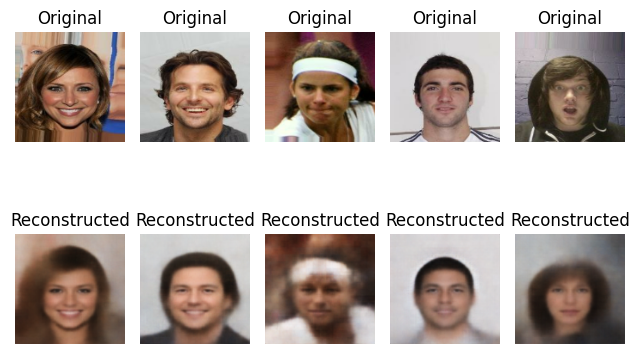

In [39]:
num_images_to_show = 5

for i in range(num_images_to_show):
    # Original Image
    plt.subplot(2, num_images_to_show, i+1)
    plt.imshow(images[i].numpy())
    plt.title("Original")
    plt.axis('off')

    # Reconstructed Image
    plt.subplot(2, num_images_to_show, i+1+num_images_to_show)
    plt.imshow(predictions[i])
    plt.title("Reconstructed")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
vae.save('my_vae_model')

In [40]:
#decoder_model = loaded_vae.get_layer("model")

##construct decoder model from the combined vae model
# Create an input placeholder for latent vectors
decoder_input = tf.keras.layers.Input(shape=(latent_dim,), name="decoder_input")

# Get the 'model' layer, which is our decoder
model_layer = vae.get_layer("model")

# Use the 'model' layer (which represents our decoder) to produce the output
decoded_output = model_layer(decoder_input)


decoder_model = tf.keras.Model(decoder_input, decoded_output)



1/1 [==============================] - 0s 18ms/step


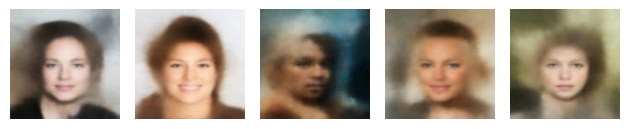

In [44]:
def generate_images(decoder, num_samples, latent_dim):

    # Sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(num_samples, latent_dim))

    # Decode them to fake images
    generated_images = decoder.predict(random_latent_vectors)

    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(generated_images[i])
        plt.axis("off")

    plt.tight_layout()
    plt.show()


generate_images(decoder_model, 5, latent_dim)

In [ ]:
!zip -r /content/vae.zip /content/my_vae_model
